# Assessing the ICON-ModEx ML models

## Motivation
With the respiration rate data spanning many orders of magnitude, it would seem like a good idea to apply a log10 (or other transform) on the target (i.e. the respiration rate) with the TransformedTargetRegressor option in the `scikit-learn` models. All trained ML models with this built-in, optional transformer will automatically read in data, transform it, train or predict, and then apply the inverse transform. "Baking in" the transformer to the ML model means that whoever uses the model later does not need to go through the process of applying the transformer.

In an ideal world, we could use the [Yeo-Johnson transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) because it does a good job handling a variety of cases.  In practice however, coupling the YJ transform (and other power transformers) to the hyperparameter optimization implemented within the SuperLeaner results in lots of internal NaN values that cause training to crash.  My guess is that the wide range of hyperparameters that we search through may result in lots of intermediate off-the-wall values that the YJ transform is not prepared to handle.

So, in practice, I implemented my own [log10 transform/inverse](https://github.com/parallelworks/sl_core/blob/main/sample_inputs/superlearner_conf_TTR_mms_log10_neg.py) that uses both the log10 and **hard coded** (CAUTION!!!) limits to a MinMaxScaler for the WHONDRS data set. Since the MinMaxScaler is applied **after** the log10, this means that the MinMaxScaler limits `[-2.0,4.0]` are orders of magnitude (i.e. 0.01 to 10000), not actual values. This notebook is designed to check how this log10 transformation performs compared to the standard approach which uses only (automated range) MinMaxScalers.

Furthermore, neither the YJ or custom transformer discussed above will map a bimodal distribution to a unimodal distribution. In general, ML models perform well when the inputs and outputs are similar to Gaussian (unimodal) distributions. As such, we also test here the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) because this transformer can map bimodal distributions to Guassian (unimodal). However, it is likely that we don't have enough data to properly train this transformer so the results here are likely not generalizable to other data sets.

A very nice, general graphical comparision between various transformers is [linked here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_map_data_to_normal.html) and a practical example of why you want to consider a transformer is [linked here](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html).

## Important behind the scenes information
Here, I am assuming that this notebook is running in a Linux context (e.g. pull a [container that runs a local Jupyter server](https://hub.docker.com/r/jupyter/datascience-notebook) and open the notebook therein). This code will switch branches within a repository that it downloads from GitHub to load the data for side by side comparisions. It will then delete the source repository and retain only the harvested data used for plotting. The harvested data will be saved alongside this notebook here. 

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Number of independent SuperLearners
num_sl = 10

# Number of histogram bins
num_bins = 25

# Large/small respiration boundary value
rr_bnd = -500.0

# Function to return the percent of positive 
# values in a given dataframe column
def get_percent_positive(df_in,target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'):
    num_pos = np.shape(
        df_in[df_in[target_name] > 0])[0]
    num_all = np.shape(df_in)[0]
    return 100.0*num_pos/num_all

# Function to return correlation coefficient for two columns in a dataframe.
def c2c_r2(input):
    corrcoeff = np.min(np.min(np.corrcoef(input['target'],y=input['predicted'])))
    return np.multiply(corrcoeff,corrcoeff)

# Function to return correlation coefficient for two columns in a dataframe in log10 space.
def c2c_r2_log(input):
    c1 = np.log10(np.abs(input['target']))
    c2 = np.log10(np.abs(input['predicted']))
    corrcoeff = np.min(np.min(np.corrcoef(c1,y=c2)))
    return np.multiply(corrcoeff,corrcoeff)

## Clone source repository

In [2]:
org='parallelworks'
repo='dynamic-learning-rivers'
!git clone https://github.com/{org}/{repo}

fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.


## Grab data
The predict data are predictions of `Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment` at sites where we do not have any observations of respiration rate.  The `_CONUS` predictions are spatially filtered to just the continental US.

The train and test data were generated during the running of the SuperLearner's `predict.py` stage; the ML model is already trained and the ML model is being used to predict respiration rates at the sites we already have observations. The training set are the data used to train the ML model while the testing set was split off from the data set before training the ML model. Each SuperLearner ensemble member has a slightly different train/test split. Train and test data are all respiration rates; the `target` column is the observed value and the `predicted` column is the corresponding prediction at that site. These data sets are a concatenation of the train/test target/predicted values over all SuperLearner instances trained for a particular ModEx iteration. Since the SuperLearners are all a little different, there should be no duplicate values in the `predicted` column while there will be duplicated values (exactly `num_sl` duplicates for each value, default is 10) in the `target` column.

Switched to branch 'Oct-2023-log10'
Your branch is up to date with 'origin/Oct-2023-log10'.
Updating files: 100% (241/241), done.
Switched to branch 'Oct-2023'
Your branch is up to date with 'origin/Oct-2023'.
Updating files: 100% (251/251), done.
Switched to branch 'Oct-2023-QT'
Your branch is up to date with 'origin/Oct-2023-QT'.


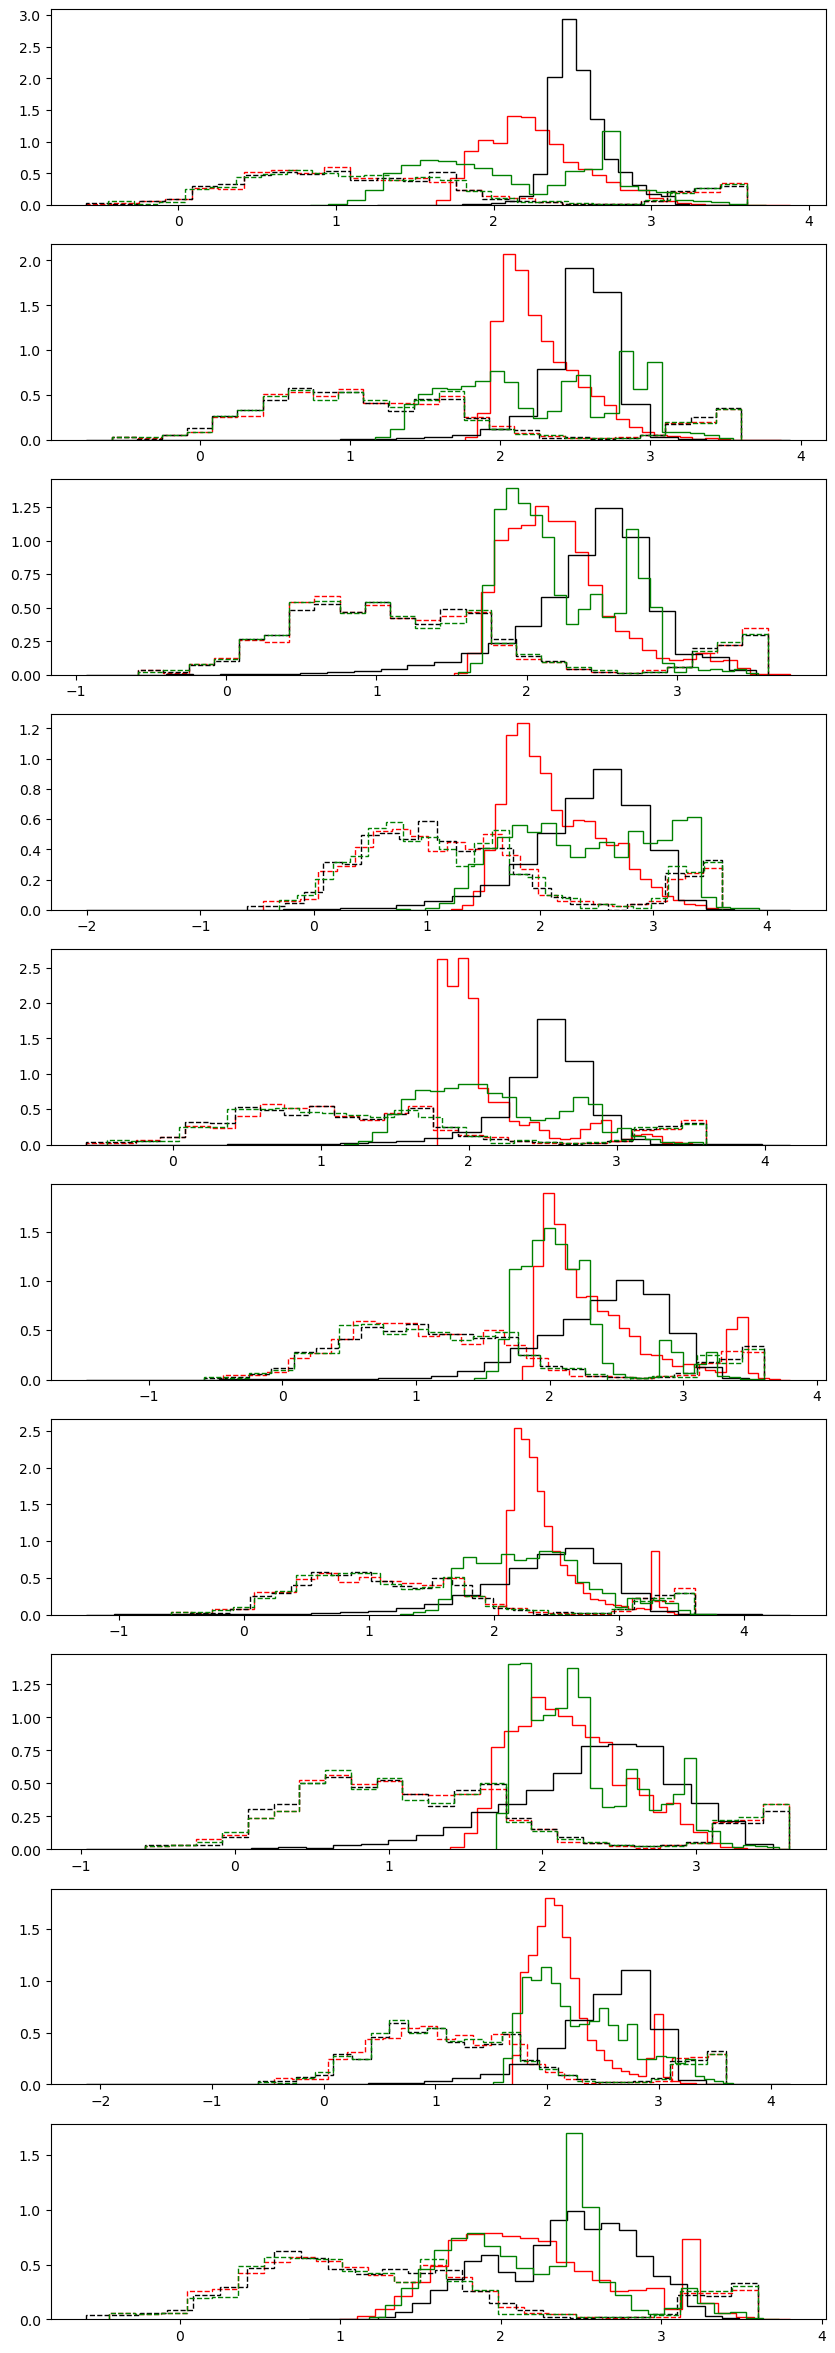

In [3]:
# Start from fresh! Delete any .csv files that may already be here
!rm -f *.csv

# List the branches we want to work with
list_branches = ['Oct-2023-log10','Oct-2023','Oct-2023-QT']
branch_colors = ['r','k','g']

# Start a figure for plotting histograms
fig, ax = plt.subplots(num_sl,1,figsize=(10,30))

for bb,branch in enumerate(list_branches):
    
    # Change to the requested branch
    !cd dynamic-learning-rivers; git checkout {branch}
    
    # This is the main output of each ICON-ModEx iteration
    # and is similar to the predict data below, but filtered
    # to just the CONUS.
    predict_conus = pd.read_csv(repo+'/output_data/filtered_predict_output.csv')
    
    # Loop over the ensemble of SuperLearners
    for ll in range(0,num_sl):
        
        train = pd.read_csv(repo+'/ml_models/sl_'+str(int(ll))+'/sl_scatter_train.csv')
        test = pd.read_csv(repo+'/ml_models/sl_'+str(int(ll))+'/sl_scatter_test.csv')
        predict = pd.read_csv(repo+'/ml_models/sl_'+str(int(ll))+'/sl_predictions.csv')
        
        if (ll == 0):
            # Load the first Superlearner to initialize storage
            train_all = train
            test_all = test
            predict_all = predict
        else:
            # Append data for the other SuperLearners
            train_all = pd.concat([train_all, train])
            test_all = pd.concat([test_all, test])
            predict_all = pd.concat([predict_all, predict])

        n, bins, patches = ax[ll].hist(
            np.log10(np.abs(predict['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
            num_bins, density=True, histtype="step", linestyle=('solid'), color=(branch_colors[bb]))
        n, bins, patches = ax[ll].hist(
            np.log10(np.abs(train['target'])),
            num_bins, density=True, histtype="step", linestyle=('dashed'), color=(branch_colors[bb]))
        #n, bins, patches = ax[ll].hist(
        #    np.log10(np.abs(test['predicted'])),
        #    num_bins, density=True, histtype="step", linestyle=('solid'), color=(branch_colors[bb]), linewidth=3)

    # Done loading raw data from each SuperLearner instance
    # Now, write output to files for publication-quality plots
    # Use the two hyphen naming convention to separate
    # branch name from file type.
    predict_conus.to_csv(branch+'--predict_conus.csv',mode='w')
    predict_all.to_csv(branch+'--predict_all.csv',mode='w')
    train_all.to_csv(branch+'--train_all.csv',mode='w')
    test_all.to_csv(branch+'--test_all.csv',mode='w')

 
-----> Working on data from branch: Oct-2023-log10
 
Percent positive in predict_all: 0.0
Percent positive in predict_conus: 0.0
Percent positive in train_all: 0.0
Percent positive in test_all: 0.0
 
R^2 for all train: 0.8818270356715233
R^2 for small train: 0.1622736104219119
R^2 for large train: 0.6322919498412857
 
-----> Working on data from branch: Oct-2023
 
Percent positive in predict_all: 5.69541422909983
Percent positive in predict_conus: 1.290516206482593
Percent positive in train_all: 3.2874015748031495
Percent positive in test_all: 3.0588235294117645
 
R^2 for all train: 0.9220574112766902
R^2 for small train: 0.11881219748198167
R^2 for large train: 0.7186879355839184
 
-----> Working on data from branch: Oct-2023-QT
 
Percent positive in predict_all: 0.0
Percent positive in predict_conus: 0.0
Percent positive in train_all: 0.0
Percent positive in test_all: 0.0
 
R^2 for all train: 0.8785057069518595
R^2 for small train: 0.26363209047520403
R^2 for large train: 0.6381898

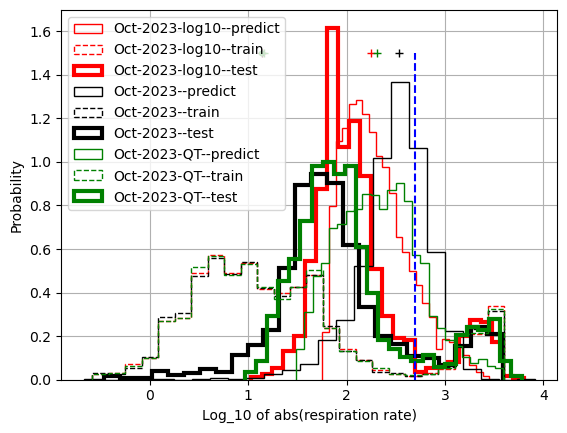

In [11]:
# Above we plotted each SuperLearner iteration separately.
# Now, plot the overall, merged distributions.

# Initialize the figure
fig, ax = plt.subplots(1,1)

# Initialize a list of lines' names to be drawn
legend_list = []

for bb,branch in enumerate(list_branches):
    
    print(' ')
    print('-----> Working on data from branch: '+branch)
    
    # Load consolidated data
    predict_all = pd.read_csv(branch+'--predict_all.csv')
    train_all = pd.read_csv(branch+'--train_all.csv')
    test_all = pd.read_csv(branch+'--test_all.csv')
    predict_conus = pd.read_csv(branch+'--predict_conus.csv')
    
    # Write out a summary of the data
    print(' ')
    print('Percent positive in predict_all: '+str(get_percent_positive(predict_all)))
    print('Percent positive in predict_conus: '+str(get_percent_positive(predict_conus)))
    print('Percent positive in train_all: '+str(get_percent_positive(train_all,'predicted')))
    print('Percent positive in test_all: '+str(get_percent_positive(test_all,'predicted')))
    print(' ')
    print('R^2 for all train: '+str(c2c_r2(train_all)))
    print('R^2 for small train: '+str(c2c_r2(np.squeeze(train_all[train_all['target'] >= rr_bnd]))))
    print('R^2 for large train: '+str(c2c_r2(np.squeeze(train_all[train_all['target'] < rr_bnd]))))

    # We want to see whether the ML model makes bimodal predictions "at scale"
    # (with many predictions) - but we cannot access the accuracy of this result
    # since there are no observed values to compare to.
    n, bins, patches = ax.hist(
        np.log10(np.abs(predict_conus['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
        num_bins, density=True, histtype="step", 
        linestyle=('solid'), color=(branch_colors[bb]))

    # We display the distribution of the training set target (observed)
    # values to show the "truth"
    n, bins, patches = ax.hist(
        np.log10(np.abs(train_all['target'])),
        num_bins, density=True, histtype="step", 
        linestyle=('dashed'), color=(branch_colors[bb]))

    # We display the distribution of the testing set predictions as
    # a classical way of assessing the ML model
    n, bins, patches = ax.hist(
        np.log10(np.abs(test_all['predicted'])),
        num_bins, density=True, histtype="step", 
        linestyle=('solid'), color=(branch_colors[bb]), linewidth=3)
    
    # Add the lines drawn to the list
    legend_list.append(branch+'--predict')
    legend_list.append(branch+'--train')
    legend_list.append(branch+'--test')
    
    # Plot the median for each histogram
    ax.plot([
        np.median(np.log10(np.abs(predict_conus['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])))],
        [1.5],branch_colors[bb]+'+',label='_nolegend_')
    ax.plot([
        np.median(np.log10(np.abs(train_all['target'])))],
        [1.5],branch_colors[bb]+'.',label='_nolegend_')
    ax.plot([
        np.median(np.log10(np.abs(test_all['target'])))],
        [1.5],branch_colors[bb]+'+',label='_nolegend_')

# Add the line for visualizing where the cut off is:
ax.plot([np.log10(np.abs(rr_bnd)),np.log10(np.abs(rr_bnd))],[0,1.5],'b--')

# Labels
ax.set_ylabel('Probability')
ax.set_xlabel('Log_10 of abs(respiration rate)')
ax.grid()
ax.legend(legend_list)

**Figure 1:** Histograms of the observed training data respiration rates (dashed, i.e. the "truth"), the predicted respiration rates in the testing data (bold, i.e. the "classical" test of the ML models), and the predicted respiration rates over the CONUS at sites where we have no samples (solid, i.e. the extrapolated, unverifyable predictions of the ML models) for the ML models built with the custom log10 transformer (red), only a simple Min/Max transformer (black), and a QuantileTransformer (green).

## What about correlations between targets and predicted values? What about classifying values - how many false classifications are there in each model?

The correlation between the targets (i.e. observations) and the values predicted by the ML models is another typical approach to assessing ML models.  Here we plot the targets (horizontal axis) versus predictions (vertical axis) at each site. Also, compute correlations between the scatter of points and quantify the percent misclassified points. For example, if we are most interested in determining whether we have a hot spot or not (as opposed to predicting the actual value of the data), how well do these two models perform?

R2 in normal units
Data set -------- Whole data set -------------- Small values -------------- Large values -------------
 
Oct-2023-log10 training set --- 0.8818270356715233 --- 0.1622736104219119 --- 0.6322919498412857
Oct-2023-log10 testing set --- 0.6798790611831781 --- 0.048571633437120336 --- 0.2818070678905428
Percent of false large predictions in small data: 2.8649386084583903
Percent of false small predictions in large data: 23.931623931623932
Overall percent misclassified: 5.764705882352941
 
Oct-2023 training set --- 0.9220574112766902 --- 0.11881219748198167 --- 0.7186879355839184
Oct-2023 testing set --- 0.7104078147948514 --- 0.038017895586286835 --- 0.28376155951426474
Percent of false large predictions in small data: 3.8539553752535496
Percent of false small predictions in large data: 21.266968325791854
Overall percent misclassified: 6.117647058823529
 
Oct-2023-QT training set --- 0.8785057069518595 --- 0.26363209047520403 --- 0.6381898171028246
Oct-2023-QT testing set

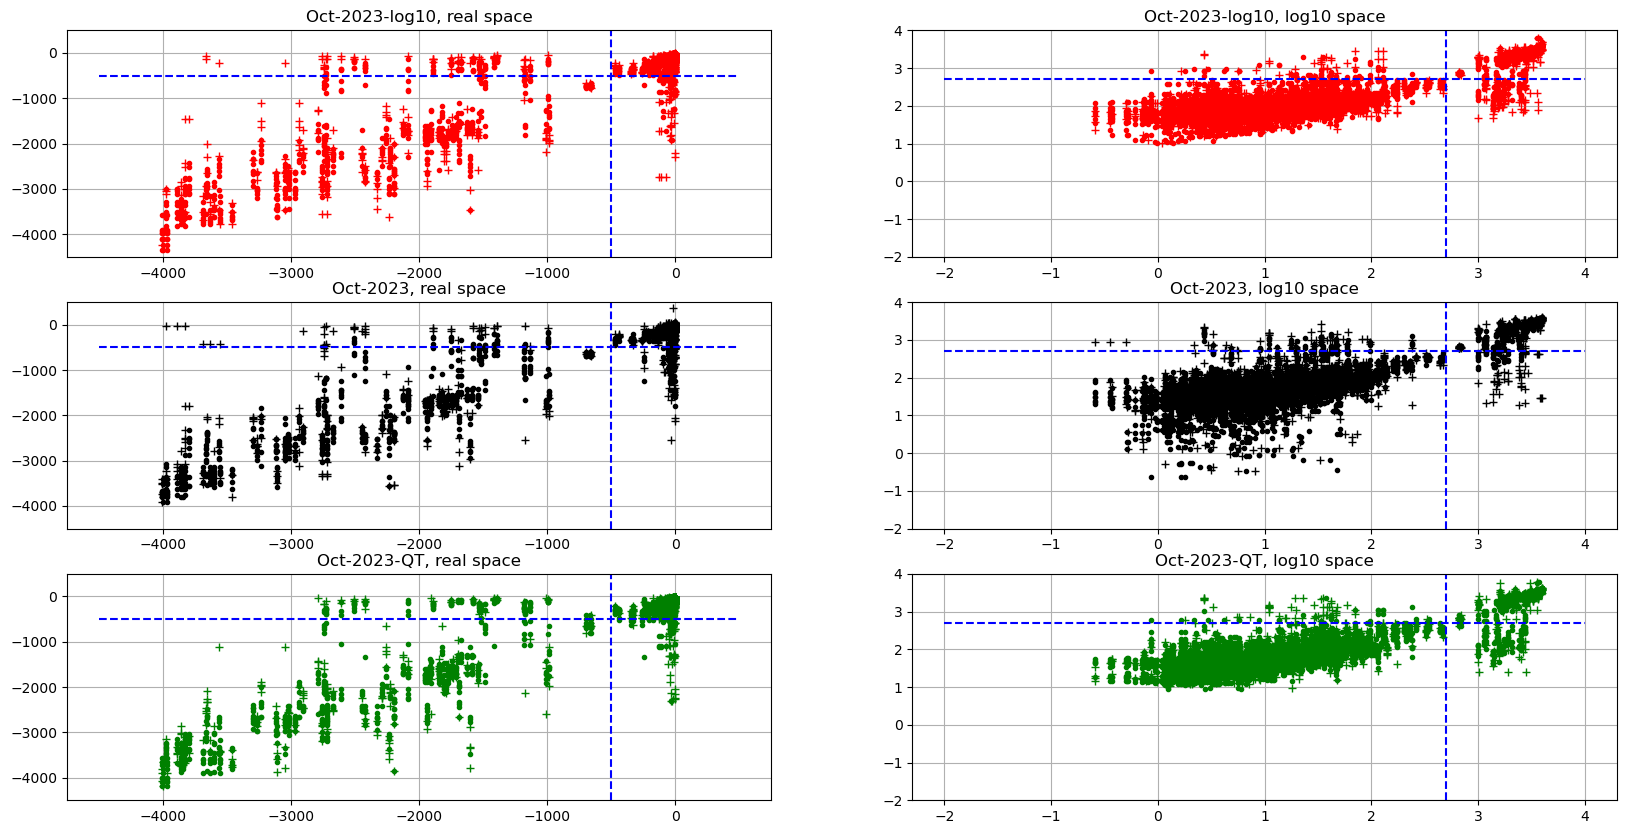

In [5]:
# Initialize the figure
fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3,2,figsize=(20,10))

# I don't strictly need to separate this out, but this is IMO
# much easier to keep track of what's going on with the axis indexing.
axis_array = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]

# Initialize a list of lines' names to be drawn
legend_list = []

# Header for the table
print("R2 in normal units")
print("Data set -------- Whole data set -------------- Small values -------------- Large values -------------")

for bb,branch in enumerate(list_branches):
    
    print(' ')
    #print('-----> Working on data from branch: '+branch)
    
    # Load consolidated data
    predict_all = pd.read_csv(branch+'--predict_all.csv')
    train_all = pd.read_csv(branch+'--train_all.csv')
    test_all = pd.read_csv(branch+'--test_all.csv')
    predict_conus = pd.read_csv(branch+'--predict_conus.csv')
    
    # Plot target versus predicted for training and testing sets
    # in normal space
    axis_array[bb][0].plot(
        train_all['target'],
        train_all['predicted'],
        branch_colors[bb]+'.')
    
    axis_array[bb][0].plot(
        test_all['target'],
        test_all['predicted'],
        branch_colors[bb]+'+')
    
    axis_array[bb][0].grid()
    axis_array[bb][0].set_ylim([-4500, 500])
    axis_array[bb][0].title.set_text(branch+', real space')
    axis_array[bb][0].plot([-4500, 500],[rr_bnd, rr_bnd],'b--')
    axis_array[bb][0].plot([rr_bnd, rr_bnd],[-4500, 500],'b--')
    
    # Plot target versus predicted for training and testing sets
    # in log10 space (may help to assess impact of log10 transform)
    axis_array[bb][1].plot(
        np.log10(np.abs(train_all['target'])),
        np.log10(np.abs(train_all['predicted'])),
        branch_colors[bb]+'.')
    
    axis_array[bb][1].plot(
        np.log10(np.abs(test_all['target'])),
        np.log10(np.abs(test_all['predicted'])),
        branch_colors[bb]+'+')
    
    axis_array[bb][1].grid()
    axis_array[bb][1].set_ylim([-2, 4])
    axis_array[bb][1].title.set_text(branch+', log10 space')
    axis_array[bb][1].plot([-2, 4],np.log10(np.abs([rr_bnd, rr_bnd])),'b--')
    axis_array[bb][1].plot(np.log10(np.abs([rr_bnd, rr_bnd])),[-2,4],'b--')
    
    # Break down the correlations for large and small respiration rates separately:
    test_small = np.squeeze(test_all[test_all['target'] >= -500.0])
    train_small = np.squeeze(train_all[train_all['target'] >= -500.0])
    
    test_large = np.squeeze(test_all[test_all['target'] < -500.0])
    train_large = np.squeeze(train_all[train_all['target'] < -500.0])
    
    print(branch+' training set --- '+
        str(c2c_r2(train_all))+' --- '+
        str(c2c_r2(train_small))+' --- '+
        str(c2c_r2(train_large)))
    
    print(branch+' testing set --- '+
        str(c2c_r2(test_all))+' --- '+
        str(c2c_r2(test_small))+' --- '+
        str(c2c_r2(test_large)))
    
    # Find the number of false large in small data
    print('Percent of false large predictions in small data: '+
        str(100.0*np.shape(test_small[test_small['predicted'] < -500])[0]/np.shape(test_small)[0]))

    print('Percent of false small predictions in large data: '+
        str(100.0*np.shape(test_large[test_large['predicted'] >= -500])[0]/np.shape(test_large)[0]))
    
    print('Overall percent misclassified: '+
        str(100.0*(np.shape(test_large[test_large['predicted'] >= -500])[0] + np.shape(test_small[test_small['predicted'] < -500])[0])/np.shape(test_all)[0]))
    

# Why are the CONUS predictions not bimodal?
I think that it is possible that many of the sites where we don't have any observations fall outside the range of the training data. If that is the case, then the ML models will have difficulty because they are **extrapolating** (making preditions on sites that do not fit the profile of what they have been trained with) rather than **interpolating** (making predictions on sites that broadly fit within the envelope of the training data). Let's see if this is indeed the case.

Predict RA_SO has NaNs: 0
Train   RA_SO has NaNs: 3
Predict RA_dm has NaNs: 0
Train   RA_dm has NaNs: 3
Predict run_mm_cyr has NaNs: 0
Train   run_mm_cyr has NaNs: 3
Predict dor_pc_pva has NaNs: 0
Train   dor_pc_pva has NaNs: 3
Predict gwt_cm_cav has NaNs: 0
Train   gwt_cm_cav has NaNs: 3
Predict ele_mt_cav has NaNs: 0
Train   ele_mt_cav has NaNs: 3
Predict slp_dg_cav has NaNs: 0
Train   slp_dg_cav has NaNs: 3
Predict sgr_dk_rav has NaNs: 0
Train   sgr_dk_rav has NaNs: 3
Predict tmp_dc_cyr has NaNs: 0
Train   tmp_dc_cyr has NaNs: 3
Predict tmp_dc_cdi has NaNs: 0
Train   tmp_dc_cdi has NaNs: 3
Predict pre_mm_cyr has NaNs: 0
Train   pre_mm_cyr has NaNs: 3
Predict pre_mm_cdi has NaNs: 0
Train   pre_mm_cdi has NaNs: 3
Predict for_pc_cse has NaNs: 0
Train   for_pc_cse has NaNs: 3
Predict crp_pc_cse has NaNs: 0
Train   crp_pc_cse has NaNs: 3
Predict pst_pc_cse has NaNs: 0
Train   pst_pc_cse has NaNs: 3
Predict ire_pc_cse has NaNs: 0
Train   ire_pc_cse has NaNs: 3
Predict gla_pc_cse has NaNs:

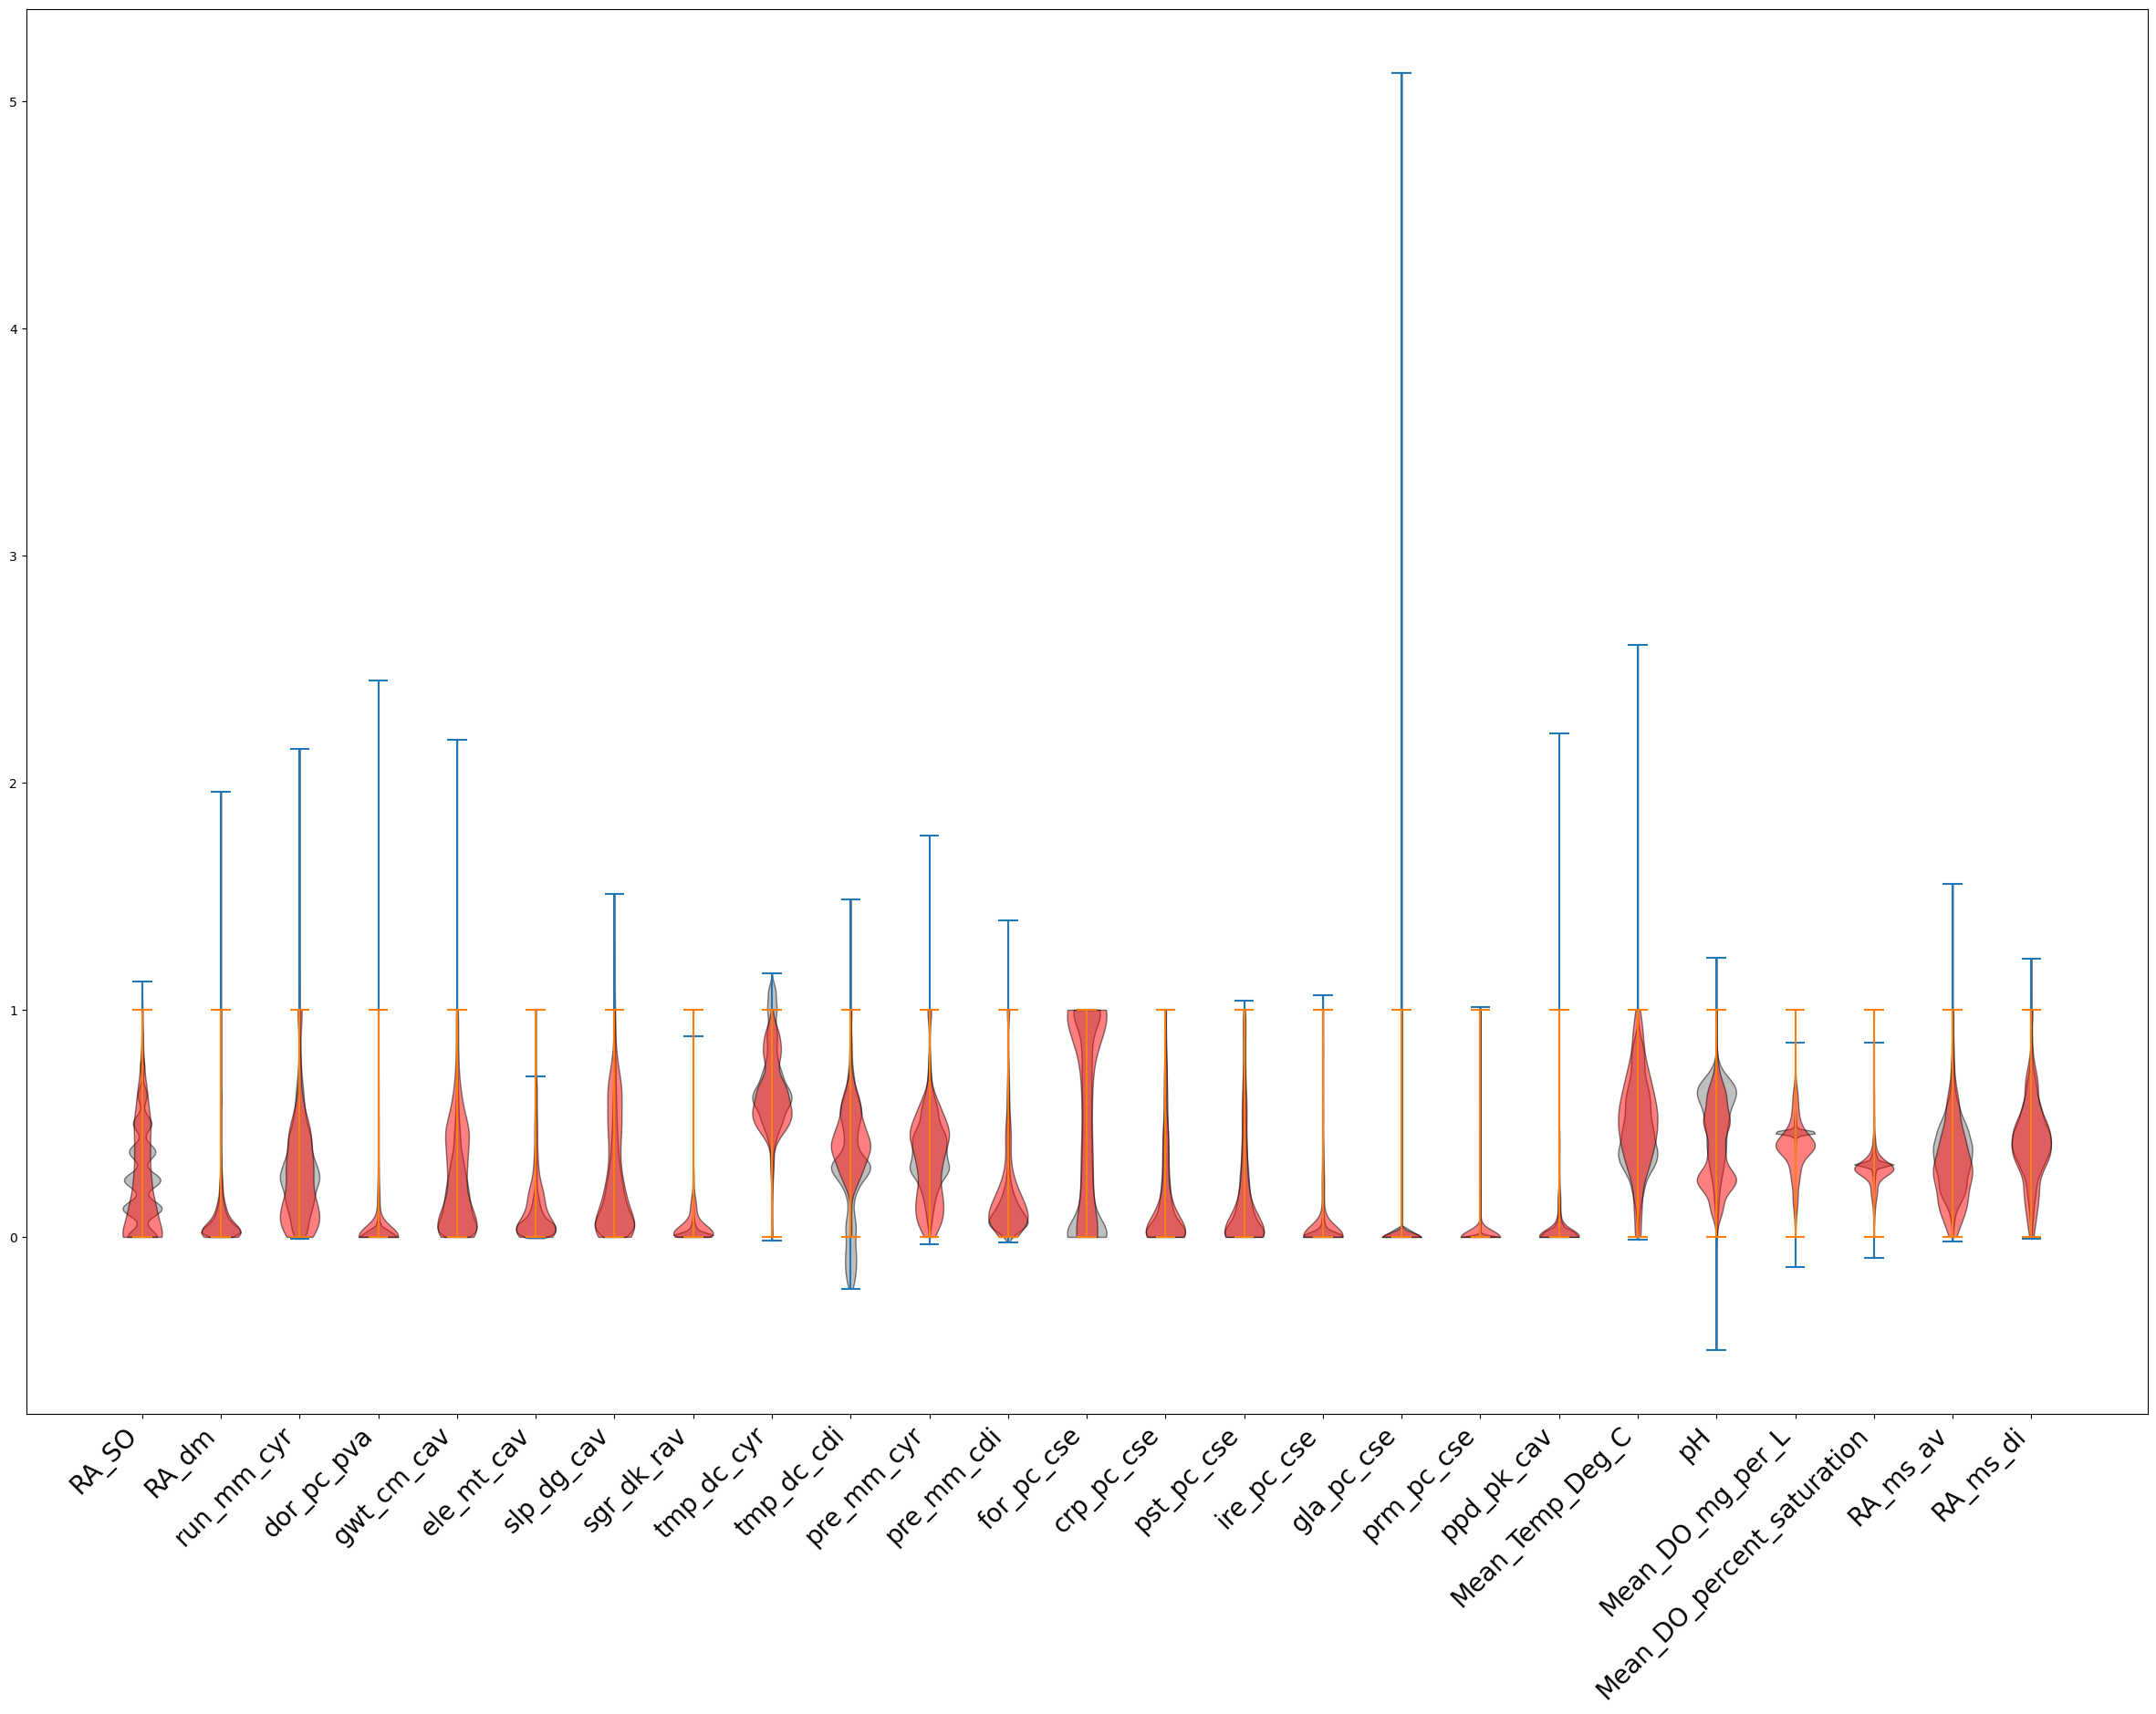

In [6]:
# Load the training and predict data with all their features.
# for a single ML model (the only difference between this branch and 
# other branches will be the number of data points. The training
# data is then randomly split into train/test for the ML for each
# SuperLeaerner instance). Broadly speaking, however, the predict
# data should be encompassed by the train data.

# This would apply to the raw, unsplit data
train = pd.read_csv(repo+'/scripts/prep_06_output_final_train.csv')
# Don't need the target
train.pop('Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment')
# There's a very large O2 value at one site - drop whole row:
train[train['Mean_DO_mg_per_L'] > 1000] = np.nan

predict = pd.read_csv(repo+'/scripts/prep_06_output_final_predict.csv')

# Count number of NaN values
for var in predict.columns:
     print('Predict '+var+' has NaNs: '+str(predict[var].isna().sum()))
     print('Train   '+var+' has NaNs: '+str(train[var].isna().sum()))

# Replace NaNs with mean values
train.fillna(train.mean(), inplace = True)
predict.fillna(predict.mean(), inplace = True)

# Train a MinMaxScaler with the training data
mms = MinMaxScaler()
mms.fit(train)
train_mms = mms.transform(train)
predict_mms = mms.transform(predict)

# Plot the range of features for train and predict.
# I am hypothesizing that some predict points do not overlap - and it 
# is those points outside the bounds of the training set that 
# "confuse" the ML models so they just default predict the average 
# value, which corresponds broadly to the "valley" of the actual 
# data since they are bimodal.

fig, ax = plt.subplots(figsize=(30,20)) #(1,2,figsize=(20,20))
#ax1.set_xticks(list(range(0,25)),predict.columns, rotation=45, ha='right', fontsize=20)
ax.set_xticks(list(range(1,26)),predict.columns, rotation=45, ha='right', fontsize=20)

#for vv, var in enumerate(predict.columns):
#    ax1.plot(vv+np.zeros(np.shape(train[var].values)),
#            train[var].values,'k.')
#    
#    ax1.plot(vv+np.zeros(np.shape(predict[var].values)),
#            predict[var].values,'r+')
#
#ax1.set_ylim([-1000, 10000])  

#===================================
parts = ax.violinplot(predict_mms)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
parts = ax.violinplot(train_mms)
for pc in parts['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

#ax.legend(train.columns)
#ax.set_ylim([0,1])

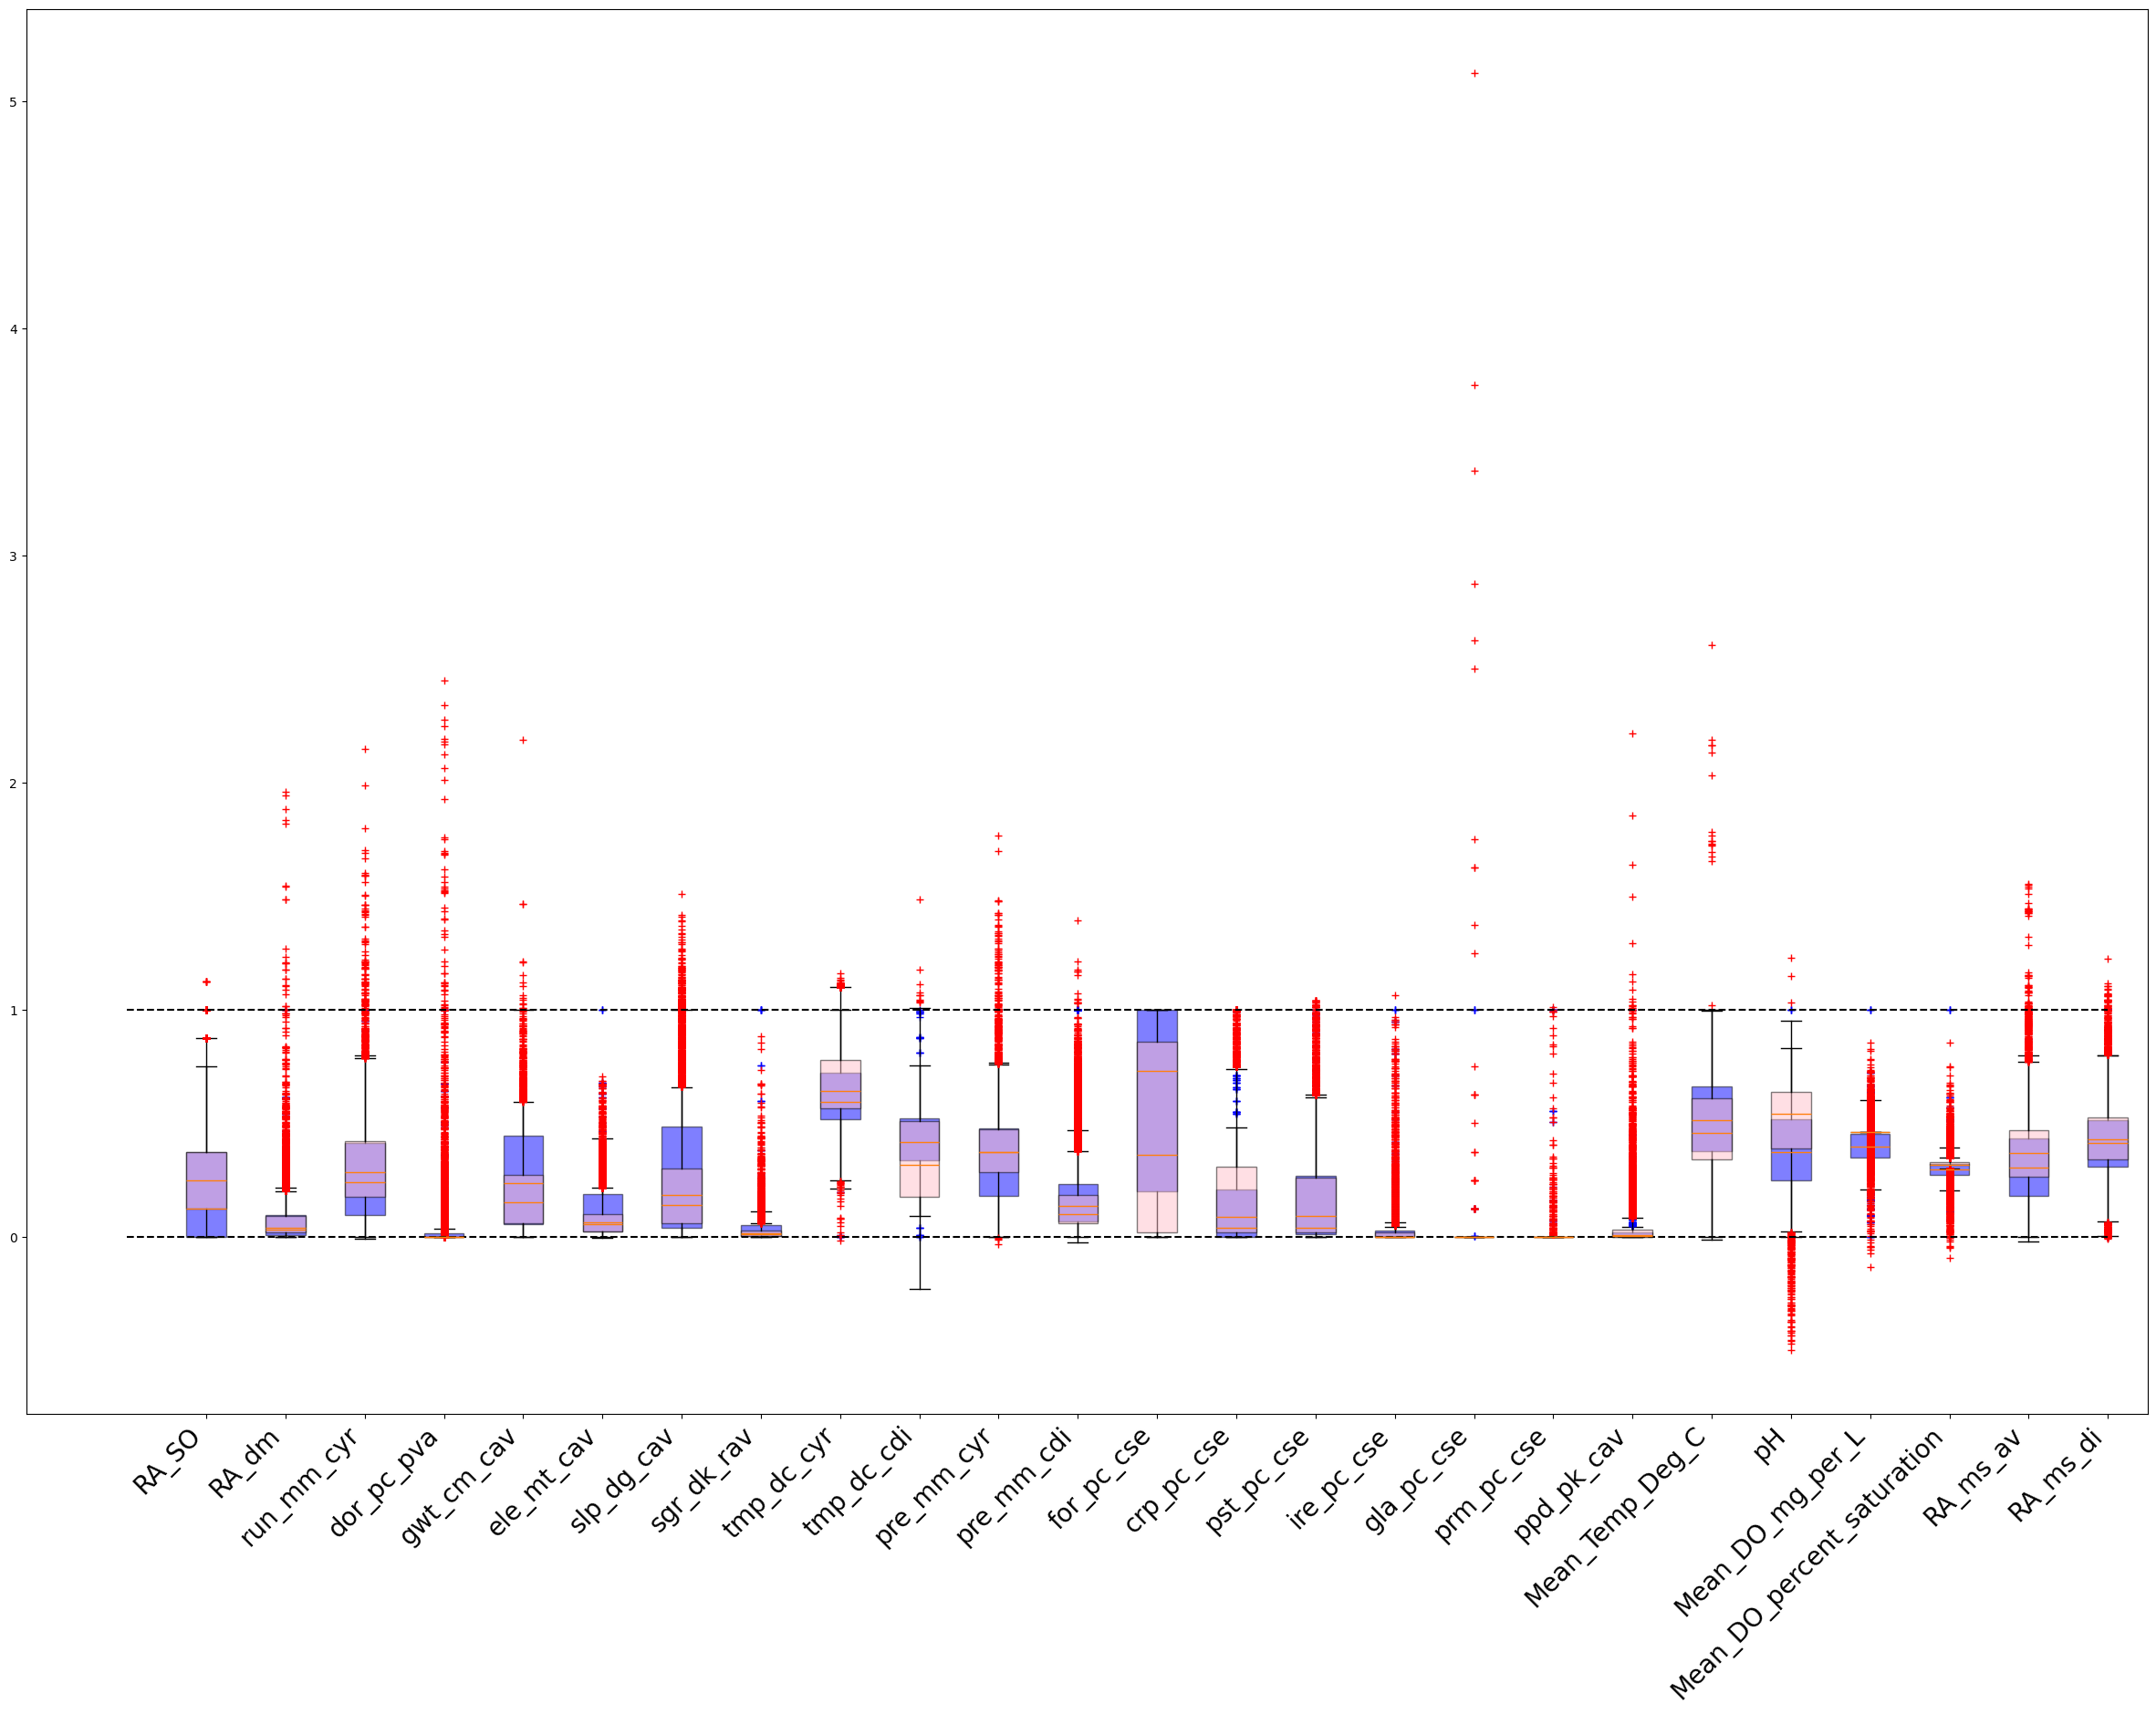

In [7]:
# Repeat as a boxplot since hard to see the number of actual outliers
fig, ax = plt.subplots(figsize=(30,20)) #(1,2,figsize=(20,20))

out = ax.boxplot(train_mms,
                 patch_artist=True,  # fill with color
                 sym='b+'
                )

# fill with colors
for patch in out['boxes']:
    patch.set_facecolor('blue')
    patch.set_alpha(0.5)

out = ax.boxplot(predict_mms,
                 patch_artist=True,  # fill with color
                 sym='r+'
                )

# fill with colors
for patch in out['boxes']:
    patch.set_facecolor('pink')
    patch.set_alpha(0.5)

ax.set_xticks(list(range(1,26)),predict.columns, rotation=45, ha='right', fontsize=20)

ax.plot([0,25],[1,1],'k--')
ax.plot([0,25],[0,0],'k--')

In [8]:
# Count the number of datapoints in predict that fall outside ranges of train
# First, row by row check for outside [0,1] - np.sum will count number of outliers on that row.
# But the whole row is a data point - we want to treat it as a single "outlier" data point, so
# simply check for any rows with counts greater than 0. So we are counting rows with outliers, not
# the total number of outliers!
bigger = np.sum(np.sum(predict_mms > 1, 1) > 0)
smaller = np.sum(np.sum(predict_mms < 0, 1) > 0)
total = np.shape(predict_mms)[0]

print(str(bigger)+' bigger points '+str(100*bigger/total)+' percent of ROWS')
print(str(smaller)+' smaller points '+str(100*smaller/total)+' percent of ROWS')


1216 bigger points 11.473862993017551 percent of ROWS
1828 smaller points 17.248537459898095 percent of ROWS


In [9]:
raw = pd.read_csv('/pw/dev/ICON-ModEx_Open_Manuscript/fig02-resp-rate-hist/dynamic-learning-rivers/input_data/ICON-ModEx_Data.csv')